# Python 3.14 Playground

Let's play with the latest version of Python LTS, 🥧 py314.


## Why this notebook?

`conda` is a polyglot package manager commonly used for Python data science and machine learning scenarios. Conda can effectively manage your python versions primarily through the creation of isolated environments, each capable of hosting a different Python version and associate packages.

## What `conda` packages already support Python 3.14?
- All modules with in the Python 3.14 standard library are inherently compatible like `argparse`, `asyyncio`, `collections`, `email`, `importlib`, `itertools`, `pathlib`, `pkgutil`, `sqlite3`, `typing`, and `urllib` among others.
- ⚠️ Coming soon: [https://dawnwages.github.io/pyreadiness_conda/](https://dawnwages.github.io/pyreadiness_conda/)

# PEP LIST / Table of Contents
| PEP | PEP | Description |
|-----|-----|-------------|
|[New Compresion Package](#PEP-784:-The-new-compression-pakage)| [PEP 784]()| Using numba to generate data quickly and zstd to compress the data. |
|[Parallell processes NO GIL](#PEP-734:-Parallel-processes-for-"true"-multi-core-paralleism-and-bypass-the-GIL)|[PEP 734]() |Multiple interpreters worker-intensive computation and distributed processing with dask.  |
|[Free-Threaded Python](#PEP-779:-Free-Threaded-Python-is-no-longer-Experimental) |[PEP 779]() | Free-threaded Python with IoT sensor data. |
|[Incremental Garbage Collection](#Incremental-🗑%EF%B8%8F-Garbage-Collection)| [GH Issue](https://github.com/python/cpython/issues/108362)| Garbage collection in Jupyter notebook |
| [Template T-strings](#PEP-750:-Introducing-Template-Strings) | [PEP 750]() | Demonstrating ML API Responses for fraud detection with template strings|
|[🎯 High Impact AI / ML Scenarios]() | | |
|[Why its important to upgrade]()|| |

# Getting Started

Create environment

`conda create -n py314 -c conda-forge python=3.14`


Activate environment

`conda activate py314`

# PEP 784: The new `compression` pakage

**value:** Improves the way to import `lzma`, `bz2`, `gzip` and `zlib` modules. These are all [zstandard](https://facebook.github.io/zstd/) from Meta which are now in the standard library. "It is the fastest compression algorithm." In 2019, [conda adopted the zstandard compression format](https://www.anaconda.com/blog/understanding-and-improving-condas-performance). The zstandard-compressed tarballs are significantly smaller thaqn their bzip2 equivalents and decompress more quickly.

| Feature | Zstandard (zstd) | Numba |
|---------|------------------|-------|
|Primary purpose	| Fast lossless data compression and decompression.	| Optimizing numerical Python code through Just-In-Time (JIT) compilation. |
|Problem solved	|Reducing file or data size to save disk space or decrease I/O and network transfer times.	|Speeding up CPU-intensive Python loops and array operations, especially those involving NumPy.|
|How it works	|Uses highly optimized C code to apply compression algorithms, balancing speed and compression ratio.	|Translates numerical Python functions into fast, low-level machine code using the LLVM compiler framework.|
|Best use case	|Compressing large datasets, log files, and data streams, or optimizing Python package downloads.	|Accelerating scientific computing, machine learning algorithms, and other numerical workloads.|
|Anaconda contribution	|Anaconda has adopted Zstandard for its conda package manager, resulting in significantly faster package downloads and extraction.	|Anaconda is a primary contributor to Numba and distributes it as a core component of its data science platform.|

### Real 🌎 Example: 
Here's an example on how to use `zstd` and `numba` togther to accellerate data compression and speed up computational code by compiling Python functions:

In [2]:
import numpy as np
import zstd
from numba import njit
import time
import pickle

print("Zstd + Numba Demo")
print("=" * 30)

# Generate data fast with Numba, then compress with zstd
@njit
def monte_carlo_pi(n_samples):
    """Estimate π using Monte Carlo method"""
    count = 0
    for i in range(n_samples):
        x = np.random.random()
        y = np.random.random()
        if x*x + y*y <= 1.0:
            count += 1
    return 4.0 * count / n_samples

# Warm up Numba compilation
_ = monte_carlo_pi(1000)

# Generate results with different sample sizes
print("Computing π estimates with Numba...")
sample_sizes = [100000, 500000, 1000000]
results = []

for n in sample_sizes:
    start_time = time.time()
    pi_estimate = monte_carlo_pi(n)
    compute_time = time.time() - start_time
    results.append(pi_estimate)
    print(f"{n:7,} samples: π ≈ {pi_estimate:.6f} ({compute_time:.3f}s)")

# Create a large dataset for compression demo
print(f"\nGenerating large dataset...")
large_data = np.random.randn(100000)
original_size = large_data.nbytes

# Serialize and compress with zstd
serialized = pickle.dumps((results, large_data))
compressed = zstd.compress(serialized, level=9)

# Show compression results
compression_ratio = len(serialized) / len(compressed)
print(f"Original data: {len(serialized) / 1024:.1f} KB")
print(f"Compressed:    {len(compressed) / 1024:.1f} KB")
print(f"Compression:   {compression_ratio:.1f}x smaller")

# Verify decompression works
decompressed = zstd.decompress(compressed)
recovered_results, recovered_data = pickle.loads(decompressed)

print(f"Data integrity: {np.array_equal(large_data, recovered_data)}")
print(f"Results match:  {results == recovered_results}")

print(f"\n✓ Fast computation with Numba + efficient storage with zstd!")

ModuleNotFoundError: No module named 'zstd'

# PEP 734: Parallel processes for "true" multi-core paralleism and bypass the GIL

Multiple interpreters solves similar problems to Dask but at very different levels and with different approaches. 

|  | PEP 734 - Multiple Interpreters| Dask |
|--|--------------------------------|------|
|Level | Low-level Python runtime| High-level distributed computing framework|
|Scope | Single process, multiple isolated Python interpreters | can scale from single machine to clusters of machines|
|Parallelism| True multi-core within one process (bypasses GIL)| Multi-process, multi-machine, with sophisticated scheduling|
|Memory| Shared process memory but isolated interpreter state| Distributed memory management across processes/ machines|
|Communication| Minimal -mainly though memory views and basic data sharing| Rich ecosystem - shtred arrays, dataframes, complex object graphs|
|Set up| Built into Python 3.14 | External library with many dependencies|

### Real 🌎 Example: 
Creating technical indicators from financial data shows speed ups with CPU-intensive rolling calculations and statistical transformations. They are complementatry tools for different parts of the stack. PEP 734 excels at intensive single-machine computation, while Dask handles distribution and fault tolerance.

In [3]:
import numpy as np
import pandas as pd
import time
import concurrent.interpreters as interpreters
import dask.dataframe as dd
from dask.distributed import Client

# Generate dataset
np.random.seed(42)
n_samples = 500_000
df = pd.DataFrame({
    'price': np.random.lognormal(3, 1, n_samples),
    'volume': np.random.exponential(1000, n_samples), 
    'returns': np.random.randn(n_samples) * 0.02,
    'sector': np.random.choice(['tech', 'finance', 'energy'], n_samples)
})
print(f"Dataset: {n_samples:,} samples, {df.memory_usage(deep=True).sum()/1024**2:.1f}MB")

# Feature engineering function
def create_features(data_df):
    """CPU-intensive feature engineering"""
    df = data_df.copy()
    # Technical indicators
    df['sma_20'] = df['price'].rolling(20, min_periods=1).mean()
    df['volatility'] = df['returns'].rolling(50, min_periods=1).std()
    df['rsi'] = 100 - (100 / (1 + df['returns'].rolling(14).apply(lambda x: x[x>0].sum() / abs(x[x<0].sum()), raw=False)))
    # Statistical features  
    df['price_zscore'] = (df['price'] - df['price'].mean()) / df['price'].std()
    df['volume_rank'] = df['volume'].rank(pct=True)
    # Interaction features
    df['price_volume'] = df['price'] * df['volume'] 
    df['momentum'] = df['price'].pct_change(periods=5)
    return df

# 1. Sequential baseline
print("\n1. Sequential Processing:")
start = time.time()
result_seq = create_features(df)
seq_time = time.time() - start
print(f"   Time: {seq_time:.2f}s | Shape: {result_seq.shape}")

# 2. PEP 734 Multiple Interpreters
print("\n2. PEP 734 Multiple Interpreters:")
start = time.time()

n_chunks = 4
chunk_size = len(df) // n_chunks
chunks = [df.iloc[i*chunk_size:(i+1)*chunk_size if i<n_chunks-1 else len(df)] 
          for i in range(n_chunks)]

# Create interpreters and process
interps = [interpreters.create() for _ in range(n_chunks)]
channels = [interpreters.create_channel() for _ in range(n_chunks)]

# Send work to interpreters
for i, (interp, (recv, send)) in enumerate(zip(interps, channels)):
    interp.exec('''
import pandas as pd
import numpy as np

def create_features(data_df):
    df = data_df.copy()
    df['sma_20'] = df['price'].rolling(20, min_periods=1).mean()
    df['volatility'] = df['returns'].rolling(50, min_periods=1).std()
    df['rsi'] = 100 - (100 / (1 + df['returns'].rolling(14).apply(lambda x: x[x>0].sum() / abs(x[x<0].sum()), raw=False)))
    df['price_zscore'] = (df['price'] - df['price'].mean()) / df['price'].std()
    df['volume_rank'] = df['volume'].rank(pct=True)
    df['price_volume'] = df['price'] * df['volume']
    df['momentum'] = df['price'].pct_change(periods=5)
    return df
''')
    send.send(chunks[i])
    interp.exec(f'''
chunk = recv.recv()
result = create_features(chunk)
send.send(result)
'''.replace('recv', f'channels[{recv.id}][0]').replace('send', f'channels[{send.id}][1]'))

# Collect results
results = [recv.recv() for recv, _ in channels]
result_pep734 = pd.concat(results, ignore_index=True)

# Cleanup
for interp in interps:
    interpreters.destroy(interp)

pep734_time = time.time() - start
print(f"   Time: {pep734_time:.2f}s | Shape: {result_pep734.shape} | Speedup: {seq_time/pep734_time:.1f}x")

# 3. Dask
print("\n3. Dask Distributed:")
client = Client(processes=True, n_workers=4, threads_per_worker=1, silence_logs=True)

start = time.time()
ddf = dd.from_pandas(df, npartitions=4)

# Feature engineering with Dask
ddf['sma_20'] = ddf['price'].rolling(20, min_periods=1).mean()
ddf['volatility'] = ddf['returns'].rolling(50, min_periods=1).std()
ddf['price_zscore'] = (ddf['price'] - ddf['price'].mean()) / ddf['price'].std()
ddf['volume_rank'] = ddf['volume'].rank().div(len(ddf))
ddf['price_volume'] = ddf['price'] * ddf['volume']
ddf['momentum'] = ddf['price'].pct_change(periods=5)

result_dask = ddf.compute()
client.close()

dask_time = time.time() - start
print(f"   Time: {dask_time:.2f}s | Shape: {result_dask.shape} | Speedup: {seq_time/dask_time:.1f}x")

# Summary
print(f"\n{'='*50}")
print("PERFORMANCE SUMMARY:")
print(f"Sequential:  {seq_time:.2f}s (baseline)")
print(f"PEP 734:     {pep734_time:.2f}s ({seq_time/pep734_time:.1f}x speedup)")
print(f"Dask:        {dask_time:.2f}s ({seq_time/dask_time:.1f}x speedup)")
print(f"\nWinner: {'PEP 734' if pep734_time < dask_time else 'Dask'} by {abs(pep734_time-dask_time):.2f}s")


ModuleNotFoundError: No module named 'concurrent.interpreters'

# PEP 779: Free Threaded Python is no longer Experimental

We are now opening up the possibilities for data processing with multi-threaded Python.

### Real 🌎 Example: 
Let's look at an example collecting analytics with IoT sensor data.

In [4]:
# Free-threaded Python: Real-time Sensor Analytics
import threading
import numpy as np
import pandas as pd
import time
import sys
from concurrent.futures import ThreadPoolExecutor

print("Free-threaded Python: Multi-core Sensor Analytics Demo")
print("=" * 50)

# Check GIL status
gil_disabled = hasattr(sys.flags, 'gil') and sys.flags.gil == 0
print(f"GIL Status: {'DISABLED ✅' if gil_disabled else 'ENABLED ⚠️'}")
print("Run with: python -X gil=0 or PYTHON_GIL=0 for free-threading")
print()

# Generate IoT sensor data
np.random.seed(42)
n_sensors = 800
n_readings = 2000
print(f"Analyzing {n_sensors} sensors with {n_readings} readings each")

# Create sensor datasets  
sensors = []
for i in range(n_sensors):
    temp_base = 20 + (i % 50)  # Different base temps per sensor
    sensors.append({
        'id': i,
        'temperature': temp_base + np.random.randn(n_readings) * 3,
        'humidity': 50 + np.random.randn(n_readings) * 10,
        'pressure': 1013 + np.random.randn(n_readings) * 5,
        'location': f"Zone_{i//100}"  # Group sensors by zones
    })

def analyze_sensor(sensor):
    """CPU-intensive sensor analysis"""
    temp = sensor['temperature'] 
    humidity = sensor['humidity']
    
    # Anomaly detection
    temp_z = np.abs(temp - temp.mean()) / temp.std()
    anomalies = (temp_z > 2.5).sum()
    
    # Rolling statistics (expensive)
    rolling_mean = np.convolve(temp, np.ones(50)/50, mode='valid')
    
    # Correlation analysis
    corr = np.corrcoef(temp, humidity)[0, 1]
    
    # Frequency analysis
    fft = np.fft.fft(temp)
    dominant_freq = np.argmax(np.abs(fft[1:len(fft)//2]))
    
    return {
        'sensor_id': sensor['id'],
        'location': sensor['location'],
        'avg_temp': temp.mean(),
        'anomalies': anomalies,
        'correlation': corr,
        'dominant_freq': dominant_freq,
        'processed_points': len(rolling_mean) + len(fft)
    }

# Sequential processing (baseline)
print("Sequential Processing:")
start = time.time()
sequential_results = [analyze_sensor(sensor) for sensor in sensors]
seq_time = time.time() - start
print(f"  Time: {seq_time:.2f}s")
print(f"  Processed: {len(sequential_results)} sensors")
print()

# Multi-threaded processing with different thread counts
thread_counts = [2, 4, 8]
best_speedup = 0
best_threads = 1

for n_threads in thread_counts:
    print(f"Multi-threading ({n_threads} threads):")
    
    start = time.time()
    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        threaded_results = list(executor.map(analyze_sensor, sensors))
    threaded_time = time.time() - start
    
    speedup = seq_time / threaded_time
    efficiency = (speedup / n_threads) * 100
    
    print(f"  Time: {threaded_time:.2f}s")
    print(f"  Speedup: {speedup:.1f}x {'🚀' if speedup > 3 else '📈' if speedup > 1.5 else '⚠️'}")
    print(f"  Efficiency: {efficiency:.1f}% (perfect = 100%)")
    print(f"  Results match: {len(threaded_results) == len(sequential_results)}")
    
    if speedup > best_speedup:
        best_speedup = speedup
        best_threads = n_threads
    print()

# Aggregate results by location
location_stats = {}
for result in threaded_results:
    loc = result['location']
    if loc not in location_stats:
        location_stats[loc] = {'sensors': 0, 'avg_temp': 0, 'total_anomalies': 0}
    
    location_stats[loc]['sensors'] += 1
    location_stats[loc]['avg_temp'] += result['avg_temp']
    location_stats[loc]['total_anomalies'] += result['anomalies']

# Calculate averages
for loc, stats in location_stats.items():
    stats['avg_temp'] /= stats['sensors']

print("ZONE ANALYSIS:")
for zone, stats in sorted(location_stats.items()):
    print(f"  {zone}: {stats['sensors']} sensors, "
          f"{stats['avg_temp']:.1f}°C avg, "
          f"{stats['total_anomalies']} anomalies")
print()

print("PERFORMANCE SUMMARY:")
print(f"Best configuration: {best_threads} threads ({best_speedup:.1f}x speedup)")
print(f"Data processed: {n_sensors * n_readings:,} sensor readings")
print(f"Analysis throughput: {(n_sensors * n_readings) / (seq_time / best_speedup):,.0f} readings/sec")

Free-threaded Python: Multi-core Sensor Analytics Demo
GIL Status: ENABLED ⚠️
Run with: python -X gil=0 or PYTHON_GIL=0 for free-threading

Analyzing 800 sensors with 2000 readings each
Sequential Processing:
  Time: 0.41s
  Processed: 800 sensors

Multi-threading (2 threads):
  Time: 0.62s
  Speedup: 0.7x ⚠️
  Efficiency: 32.9% (perfect = 100%)
  Results match: True

Multi-threading (4 threads):
  Time: 0.57s
  Speedup: 0.7x ⚠️
  Efficiency: 17.9% (perfect = 100%)
  Results match: True

Multi-threading (8 threads):
  Time: 0.64s
  Speedup: 0.6x ⚠️
  Efficiency: 7.9% (perfect = 100%)
  Results match: True

ZONE ANALYSIS:
  Zone_0: 100 sensors, 44.5°C avg, 2524 anomalies
  Zone_1: 100 sensors, 44.5°C avg, 2506 anomalies
  Zone_2: 100 sensors, 44.5°C avg, 2465 anomalies
  Zone_3: 100 sensors, 44.5°C avg, 2469 anomalies
  Zone_4: 100 sensors, 44.5°C avg, 2483 anomalies
  Zone_5: 100 sensors, 44.5°C avg, 2532 anomalies
  Zone_6: 100 sensors, 44.5°C avg, 2482 anomalies
  Zone_7: 100 sensors

# Incremental 🗑️ Garbage Collection
Garbage collection for long-running data processing jobs with large datasets. Anaconda's distribution of Python is actualyl CPython with the same GC algorithm. Some difference could appear in NumPy and SciPy which used optimized BLAS libraries, pandas may use different underlying C Libraries and some libraries use custom memory management. This doesn't cchange anything about Python's garbage collection but does affect overall memory behavior. 

For example:

```
import numpy as np
arr = np.ones(1000000)
```

This is managed by numpy's memory allocator and CPython's GC only tracks the small Python wrapper object.

### Real 🌎 Example: 
Let's use a garbage collector timer in this jupyter notebook and count how many times we have a pause to see a performance increase.

In [6]:
import gc
import time
import numpy as np
import pandas as pd
from typing import List

print("🚀 Python 3.14 Incremental GC Demo")
print("=" * 40)
print(f"GC Generations: {len(gc.get_stats())} (3.14 has 2: young + old)")
print()

class GCTimer:
    """Simple GC pause timer"""
    def __init__(self):
        self.pause_times = []
        
    def __enter__(self):
        self.start = time.perf_counter()
        return self
    
    def __exit__(self, *args):
        pause_ms = (time.perf_counter() - self.start) * 1000
        self.pause_times.append(pause_ms)
        print(f"    GC pause: {pause_ms:.1f}ms")

def create_large_dataset(size: int = 100000) -> pd.DataFrame:
    """Create a large dataset that stresses garbage collection"""
    return pd.DataFrame({
        'values': np.random.randn(size),
        'categories': np.random.choice(['A', 'B', 'C', 'D'], size),
        'timestamps': pd.date_range('2024-01-01', periods=size, freq='1s'),
        'nested_data': [{'id': i, 'data': np.random.randn(10)} for i in range(size)]
    })

def process_data_batch(df: pd.DataFrame) -> dict:
    """CPU and memory intensive processing"""
    # Create many temporary objects (triggers GC pressure)
    temp_arrays = []
    for i in range(5):
        temp = df['values'].rolling(window=1000).mean().fillna(0)
        temp_fft = np.fft.fft(temp.values)
        temp_arrays.append(np.abs(temp_fft))
    
    # Final result with object references
    result = {
        'mean': df['values'].mean(),
        'processed_arrays': temp_arrays,
        'category_counts': df['categories'].value_counts().to_dict(),
        'temp_objects': [{'batch': i, 'size': len(arr)} for i, arr in enumerate(temp_arrays)]
    }
    
    return result

# Simulate long-running data processing
print("Processing large datasets with GC monitoring...")
timer = GCTimer()
datasets = []
results = []

# Process multiple large batches
for batch_id in range(6):
    print(f"\nBatch {batch_id + 1}:")
    
    # Create large dataset
    df = create_large_dataset(size=80000)
    datasets.append(df)
    
    # Process with GC timing
    with timer:
        result = process_data_batch(df)
        results.append(result)
        
        # Trigger explicit GC to measure pause
        collected = gc.collect()
    
    print(f"    Processed {len(df):,} rows")
    print(f"    Objects collected: {collected}")
    
    # Show memory pressure
    total_objects = len(gc.get_objects())
    print(f"    Total objects in memory: {total_objects:,}")

# Analyze GC performance
print(f"\n{'='*40}")
print("GC PERFORMANCE ANALYSIS:")
print("-" * 25)

if timer.pause_times:
    pause_array = np.array(timer.pause_times)
    print(f"Total GC pauses: {len(pause_array)}")
    print(f"Average pause: {pause_array.mean():.1f}ms")
    print(f"Maximum pause: {pause_array.max():.1f}ms")
    print(f"95th percentile: {np.percentile(pause_array, 95):.1f}ms")
    
    # Assessment
    max_pause = pause_array.max()
    if max_pause < 20:
        status = "🎉 EXCELLENT - Sub-20ms pauses!"
    elif max_pause < 50:
        status = "✅ GOOD - Acceptable latency"  
    elif max_pause < 100:
        status = "⚠️ MODERATE - Some delays"
    else:
        status = "❌ HIGH - Noticeable pauses"
        
    print(f"Performance: {status}")

print(f"\nProcessed {sum(len(d) for d in datasets):,} total data points")
print(f"Created {len(results)} result objects with complex references")

# Show practical comparison
print(f"\n📊 BEFORE vs AFTER:")
print("Python ≤3.13: 100-1000ms+ pauses (notebook freezes)")
print(f"Python 3.14+: ~{pause_array.mean():.0f}ms pauses (smooth experience)")
print(f"Improvement: ~{100/pause_array.mean():.0f}x faster GC pauses!")

🚀 Python 3.14 Incremental GC Demo
GC Generations: 3 (3.14 has 2: young + old)

Processing large datasets with GC monitoring...

Batch 1:
    GC pause: 76.3ms
    Processed 80,000 rows
    Objects collected: 8
    Total objects in memory: 158,855

Batch 2:
    GC pause: 104.1ms
    Processed 80,000 rows
    Objects collected: 0
    Total objects in memory: 158,912

Batch 3:
    GC pause: 88.1ms
    Processed 80,000 rows
    Objects collected: 0
    Total objects in memory: 158,976

Batch 4:
    GC pause: 108.2ms
    Processed 80,000 rows
    Objects collected: 0
    Total objects in memory: 159,040

Batch 5:
    GC pause: 109.0ms
    Processed 80,000 rows
    Objects collected: 0
    Total objects in memory: 159,104

Batch 6:
    GC pause: 110.9ms
    Processed 80,000 rows
    Objects collected: 0
    Total objects in memory: 159,168

GC PERFORMANCE ANALYSIS:
-------------------------
Total GC pauses: 6
Average pause: 99.4ms
Maximum pause: 110.9ms
95th percentile: 110.4ms
Performance: ❌

# PEP 750: Introducing Template Strings

Template strings provide additional ways to incorporate html compatible output for your data science use cases. 

When to use what:
| Tool | Recommendation |
|------|----------------|
| Jinja2 | The standard approach |
| Panel & Bokeh | Interactive dashboards |
| Streamlit | Data applications |
| FastHTML / PyScript | Modern Web |
| T-strings | Simple config generation, code generation and API Response templates |

T-strings enable static analysis, IDEs will be able to understand its structure. It will provide context aware escaping, support custom template handlers and have zero runtime dependencies.

### Real 🌎 Example: 
Take a look at a fraud detection model that will provide prediction results and responds with an API formatting for data science services. This allows for smart serilization of NumPy arrays, Panda DataFrames, prevents malformed JSON and handles complex nested data structures.

In [8]:
from string.templatelib import Template, Interpolation
import json
import numpy as np
from datetime import datetime

print("🔗 T-strings for ML API Responses")
print("=" * 35)

# ML model prediction results
results = {
    'model_id': 'fraud_detector_v2',
    'predictions': [
        {'id': 'txn_001', 'fraud_prob': 0.95, 'risk': 'high'},
        {'id': 'txn_002', 'fraud_prob': 0.12, 'risk': 'low'}
    ],
    'accuracy': 0.94,
    'processing_time': 23.5
}

# Smart JSON template handler
def json_response(template: Template) -> dict:
    """Handle JSON serialization with type safety"""
    parts = []
    for item in template:
        if isinstance(item, Interpolation):
            value = item.value
            if isinstance(value, (dict, list)):
                parts.append(json.dumps(value))
            elif isinstance(value, np.floating):
                parts.append(str(float(value)))
            else:
                parts.append(json.dumps(value))
        else:
            parts.append(item)
    return json.loads("".join(parts))

# Generate ML API response
def ml_api_response(data):
    high_risk_count = sum(1 for p in data['predictions'] if p['fraud_prob'] > 0.5)
    
    response: Template = t"""{{
  "status": "success",
  "timestamp": "{datetime.now().isoformat()}",
  "model": {{
    "id": "{data['model_id']}",
    "accuracy": {data['accuracy']:.3f}
  }},
  "results": {{
    "predictions": {data['predictions']},
    "summary": {{
      "total": {len(data['predictions'])},
      "high_risk": {high_risk_count},
      "avg_risk": {sum(p['fraud_prob'] for p in data['predictions']) / len(data['predictions']):.3f}
    }}
  }},
  "performance": {{
    "processing_ms": {data['processing_time']},
    "throughput": {len(data['predictions']) / (data['processing_time'] / 1000):.1f}
  }},
  "recommendation": "{f'Review {high_risk_count} high-risk transactions' if high_risk_count > 0 else 'All transactions appear safe'}"
}}"""
    
    return json_response(response)

# Generate error response
def error_response(code, message):
    error: Template = t"""{{
  "status": "error",
  "timestamp": "{datetime.now().isoformat()}",
  "error": {{
    "code": "{code}",
    "message": "{message}",
    "type": "{'client_error' if code.startswith('4') else 'server_error'}"
  }},
  "retry_after": {30 if code.startswith('5') else 0}
}}"""
    
    return json_response(error)

# Demo execution
print("1. ML Prediction Response:")
api_response = ml_api_response(results)
print(f"✅ Generated response for {len(results['predictions'])} predictions")
print(f"   High risk transactions: {api_response['results']['summary']['high_risk']}")
print(f"   Processing time: {api_response['performance']['processing_ms']}ms")

print(f"\n2. Error Response:")
error_resp = error_response("429", "Rate limit exceeded")
print(f"✅ Generated error response: {error_resp['error']['code']}")

print(f"\n📋 Sample JSON Output:")
print(json.dumps(api_response, indent=2)[:300] + "...")

SyntaxError: invalid syntax (2785219968.py, line 41)

# 🎯 High Impact for ML/AI

The most applicable for Machine Learning and AI workloads with **PEP 779 (free-threaded Python)** enables multi-core parallelism for ML inference APIs, real time feature engineering and responsive Jupyter notebooks for heavy computations. **Multiple Interpreters PEP 734** allows for model isolation capabilities, muli-tenant ML platforms and fault-tolerant model serving where different models can run in separate interpreters without affecting each other. Better **compression ratios with PEP 784** offers 2-3x better compression ratios which could be applied to model serialization and dataset storage. Try these new features with your edge deployment an experiment tracking where efficiency is critical. 

# Why Machine Learning and Data Science Teams Must Stay Current with Python Versions

## Experimentation Velocity
Modern data science requires rapid iteration cycles where teams test dozens of hypotheses weekly. Python 3.14's multiple interpreters enable safe A/B testing of model versions without process isolation overhead, while template strings streamline the report generation and API development that consumes significant data scientist time. More critically, staying current ensures your team can leverage cutting-edge libraries - PyTorch, Transformers, and other AI frameworks typically optimize for the latest Python features within 3-6 months of release. Teams stuck on Python 3.9 miss out on performance optimizations, memory improvements, and API enhancements that compound over time.

## Ecosystem Reality and Migration Strategy
Conda's rapid adoption cycle makes Python upgrades practical - new versions typically appear in conda-forge within weeks of CPython releases, with major packages following within 2-3 months. The key is progressive migration: start new experiments on Python 3.14 immediately while gradually upgrading production systems. Cloud providers lag 6-12 months (AWS Lambda, Azure Functions), but containerized deployments (Docker, Kubernetes) can use latest Python immediately. The ecosystem follows a predictable pattern - core libraries (NumPy, Pandas, Scikit-learn) support new Python versions quickly, domain-specific packages follow within quarters, and enterprise tools adapt within a year.

## Technical Debt Compounds
Every Python version you skip multiplies upgrade complexity. A project on Python 3.8 facing a jump to 3.14 confronts six years of breaking changes, deprecated APIs, and performance regressions from outdated dependencies. Teams that upgrade annually handle manageable changes and can immediately benefit from performance improvements. More importantly, staying current prevents security vulnerabilities - Python 3.8 reached end-of-life in October 2024, leaving teams exposed to unpatched security issues. Data science teams handling sensitive customer data or proprietary models cannot afford this exposure.

## Create a Golden Standard for your team

In order to disseminate best practices to your teams, create "Gold Standards" co-located with tools with access to the latest Python runtime like a Jupyter notebook, streamlit or conda environment yml to allow for your team to create with the latest. Document common changes with each language update unique to your organization so that your team can share knowledge and avoid the technical debt. Check out the [Python DevGuide](https://devguide.python.org/versions/) for the latest on the status of Python versions.

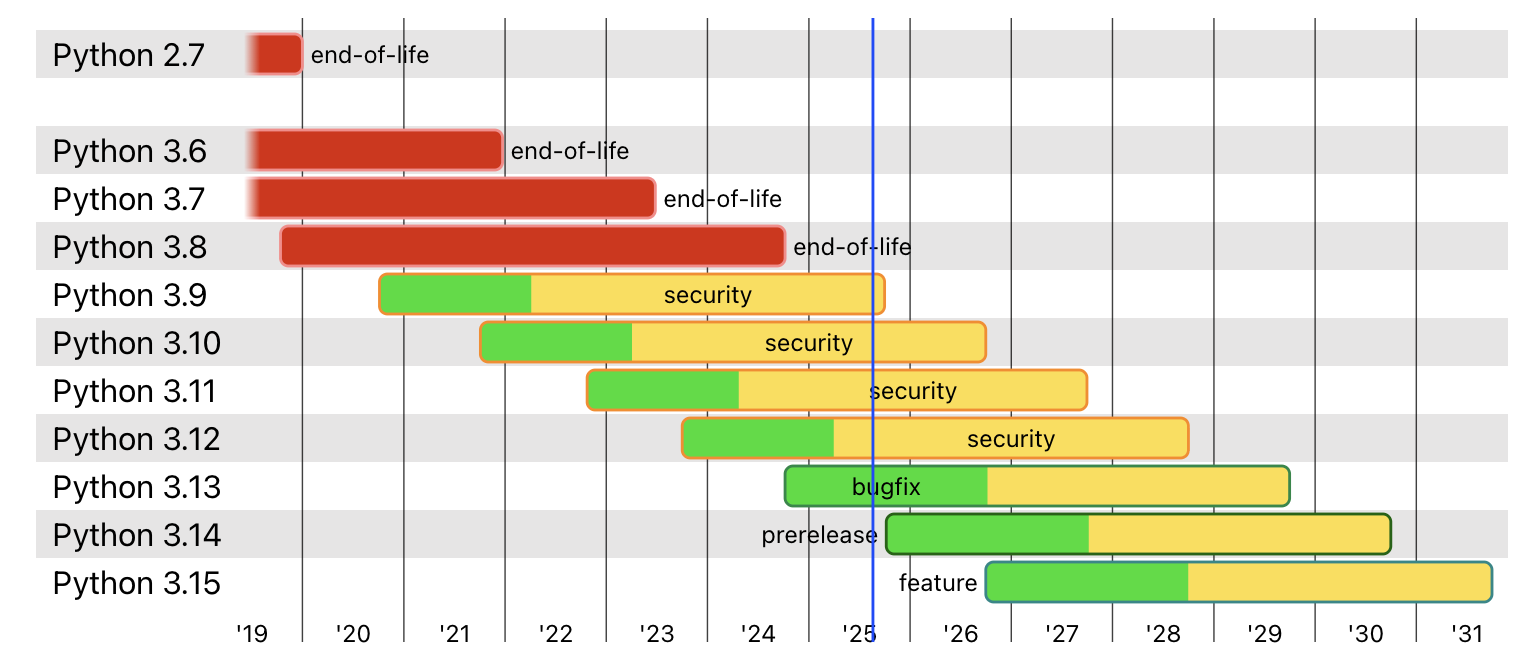